In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler, 
    PolynomialFeatures,
    KBinsDiscretizer
)
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
fina_log = pd.read_csv('data/Train.csv')
fina_log.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [3]:
finan_log = fina_log.drop(['country','year','uniqueid','relationship_with_head'], axis=1)

In [4]:
finan_log.value_counts('bank_account')

bank_account
No     20212
Yes     3312
Name: count, dtype: int64

<Axes: xlabel='bank_account', ylabel='count'>

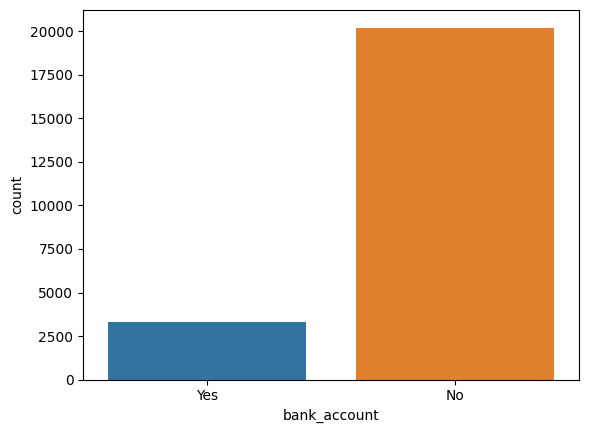

In [5]:
sns.countplot(x='bank_account', data=finan_log)

In [6]:
le = LabelEncoder()
finan_log['bank_account'] = le.fit_transform(finan_log['bank_account'])

X = finan_log.drop('bank_account', axis=1)
y = finan_log['bank_account']

In [7]:
X_train, X_test,y_train, y_test = train_test_split(X,y , test_size= 0.20, random_state=42, stratify=y)

In [8]:
num_features = list(X_train.select_dtypes(exclude=['object']).columns)
cat_features = list(X_train.select_dtypes(include=['object']).columns)

num_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaling', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3))
    ])
cat_transformer = Pipeline(steps=
                           [
        ('imputer', SimpleImputer(strategy='most_frequent')),
    
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_transformer', num_transformer, num_features),
        ('cat_transformer', cat_transformer, cat_features)
        
    ],remainder='passthrough')

In [24]:
baseline = ImbPipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('Smote', SMOTE(random_state=42)),  # Use SMOTE as a step
        ('classifier', LogisticRegression(solver='saga', max_iter=10_000))
    ])

Test-------------------
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      4043
           1       0.35      0.76      0.48       662

    accuracy                           0.76      4705
   macro avg       0.65      0.76      0.66      4705
weighted avg       0.87      0.76      0.80      4705

Accuracy score: 0.7647183846971307


Text(0.5, 1.0, 'Confusion Matrix')

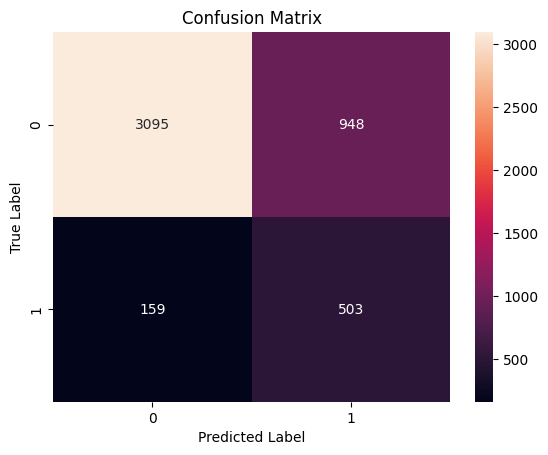

In [25]:
baseline.fit(X_train, y_train)

y_log = baseline.predict(X_test)
print('Test-------------------')
print(classification_report(y_test, y_log))
print('Accuracy score:', accuracy_score(y_test, y_log))

cm=confusion_matrix(y_test, y_log)
sns.heatmap(cm, annot=True, fmt ='g')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [27]:
param_grid = {
    
    'preprocessor__num_transformer__imputer__strategy': ['mean','median'],
    'preprocessor__num_transformer__scaling': [StandardScaler(),MinMaxScaler(), None],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1.0,10.]
}

In [28]:
from sklearn.model_selection import GridSearchCV

gscv = GridSearchCV(
    estimator=baseline,
    param_grid=param_grid,
    scoring='recall',
    cv=5, 
    n_jobs=-1,
    verbose=1
)

In [29]:
import time
# initial time
ti = time.time()

# grid-search cross-validation
%time gscv.fit(X_train,y_train)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: user 2min 43s, sys: 14.2 s, total: 2min 57s
Wall time: 2h 54min 31s
time taken: 10471.18 sec


In [30]:
pd.DataFrame(gscv.cv_results_).head()

gscv.best_params_


round(gscv.best_score_,6)

0.771029

In [31]:
gscv.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'preprocessor__num_transformer__imputer__strategy': 'mean',
 'preprocessor__num_transformer__scaling': StandardScaler()}

In [32]:
best_model = gscv.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3))]),
                                                  ['household_size',
                                                   'age_of_respondent']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['location_type',
                                                   'cellphone_access',
                                                   'gender_of_respondent',
                                                   'marital_status',
                                                   'education_level',
                                                   'job_type'])])),
                ('Smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=10000, penalty='l1',
                                    solver='saga'))])

In [33]:
best_model.fit(X_train,y_train);

test_score = best_model.score(X_test,y_test)



In [34]:
y_log_ = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      3257
           1       0.76      0.35      0.48      1448

    accuracy                           0.76      4705
   macro avg       0.76      0.65      0.66      4705
weighted avg       0.76      0.76      0.73      4705



Text(0.5, 1.0, 'Confusion Matrix')

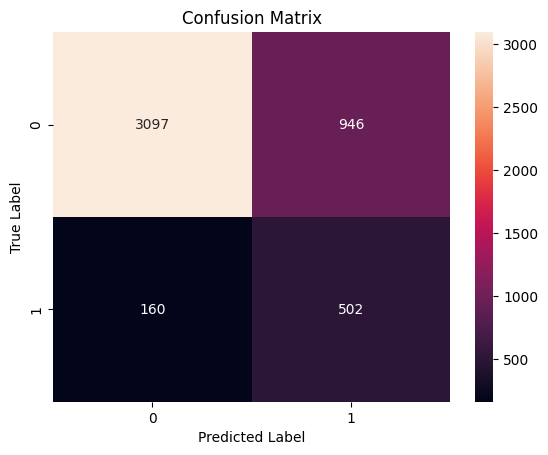

In [35]:
print(classification_report(y_log_, y_test))

cm=confusion_matrix(y_test,y_log_)
sns.heatmap(cm, annot=True, fmt ='g')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')